In [1]:
# Setup
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.data.dataset import load_density_limit_data, split_by_discharge_with_cal
from src.features.temporal import engineer_features, get_engineered_feature_names, FeatureConfig
from src.models.baseline_lr import create_baseline_pipeline
from src.evaluation.alarm_metrics import AlarmConfig, compute_alarm_metrics

plt.style.use('seaborn-v0_8-whitegrid')
print("Setup complete! ✓")

Setup complete! ✓


## 1. Load and Prepare Data

We use the MIT-PSFC Open Density Limit dataset containing ~264k time samples from ~2300 tokamak discharges.

In [2]:
# Load dataset
df = load_density_limit_data("../data/raw/DL_DataFrame.h5")
print(f"Loaded {len(df):,} samples from {df['discharge_ID'].nunique()} discharges")
print(f"Positive rate (density limit events): {df['density_limit_phase'].mean():.2%}")

Loaded 264,385 samples from 2333 discharges
Positive rate (density limit events): 1.36%


In [3]:
# Engineer physics-informed features
config = FeatureConfig(
    rolling_windows=(3, 5, 10),
    include_greenwald_proxy=True,
    include_interactions=True
)
df_eng = engineer_features(df, config)
feature_cols = get_engineered_feature_names(config)
print(f"Generated {len(feature_cols)} features including physics-informed ones")

Generated 92 features including physics-informed ones


In [4]:
# Split by discharge_ID (critical for preventing data leakage!)
train_df, cal_df, val_df, test_df = split_by_discharge_with_cal(df_eng, random_state=42)
print(f"Train: {len(train_df):,} samples from {train_df['discharge_ID'].nunique()} discharges")
print(f"Test:  {len(test_df):,} samples from {test_df['discharge_ID'].nunique()} discharges")

Train: 158,407 samples from 1399 discharges
Test:  39,827 samples from 352 discharges


## 2. Train a Simple Baseline Model

For this demo, we'll use a logistic regression baseline. The TCN model achieves better performance but takes longer to train.

In [5]:
# Train baseline
TARGET = 'density_limit_phase'

X_train = train_df[feature_cols].values
y_train = train_df[TARGET].values
X_test = test_df[feature_cols].values

model = create_baseline_pipeline()
model.fit(X_train, y_train)

# Get predictions
test_probs = model.predict_proba(X_test)[:, 1]
print(f"Model trained! Generating predictions for {len(test_df):,} test samples...")

Model trained! Generating predictions for 39,827 test samples...


## 3. Find a Discharge with an Event

Let's pick a discharge that has a density limit event so we can visualize the warning capability.

In [6]:
# Find discharges with events in test set
event_discharges = test_df[test_df[TARGET] == 1]['discharge_ID'].unique()
print(f"Found {len(event_discharges)} discharges with density limit events in test set")

# Select one with good data
for discharge_id in event_discharges:
    mask = test_df['discharge_ID'] == discharge_id
    n_samples = mask.sum()
    max_prob = test_probs[mask].max()
    if n_samples > 50 and max_prob > 0.3:
        selected_discharge = discharge_id
        print(f"\nSelected discharge {discharge_id}: {n_samples} samples, max P = {max_prob:.2f}")
        break

Found 9 discharges with density limit events in test set

Selected discharge 1000620001: 80 samples, max P = 1.00


## 4. Visualize the Early Warning

This is the key visualization: we'll show the feature traces, the model's predicted probability, and mark when the alarm triggers vs. when the actual event occurs.

In [7]:
# Get data for selected discharge
mask = test_df['discharge_ID'] == selected_discharge
discharge_df = test_df[mask].copy()
discharge_probs = test_probs[mask]

time = discharge_df['time'].values
labels = discharge_df[TARGET].values

# Set alarm threshold
THRESHOLD = 0.5

# Find event and alarm times
event_times = time[labels == 1]
alarm_times = time[discharge_probs > THRESHOLD]

event_start = event_times[0] if len(event_times) > 0 else None
first_alarm = alarm_times[0] if len(alarm_times) > 0 else None

print(f"Event starts at: t = {event_start:.3f}s" if event_start else "No event")
print(f"First alarm at:  t = {first_alarm:.3f}s" if first_alarm else "No alarm triggered")

if event_start and first_alarm and first_alarm < event_start:
    warning_time = event_start - first_alarm
    print(f"\n🎯 WARNING TIME: {warning_time:.3f} seconds!")
elif event_start and first_alarm:
    print(f"\n⚠️ Alarm triggered {first_alarm - event_start:.3f}s AFTER event (too late)")

Event starts at: t = 0.970s
First alarm at:  t = 0.790s

🎯 WARNING TIME: 0.180 seconds!


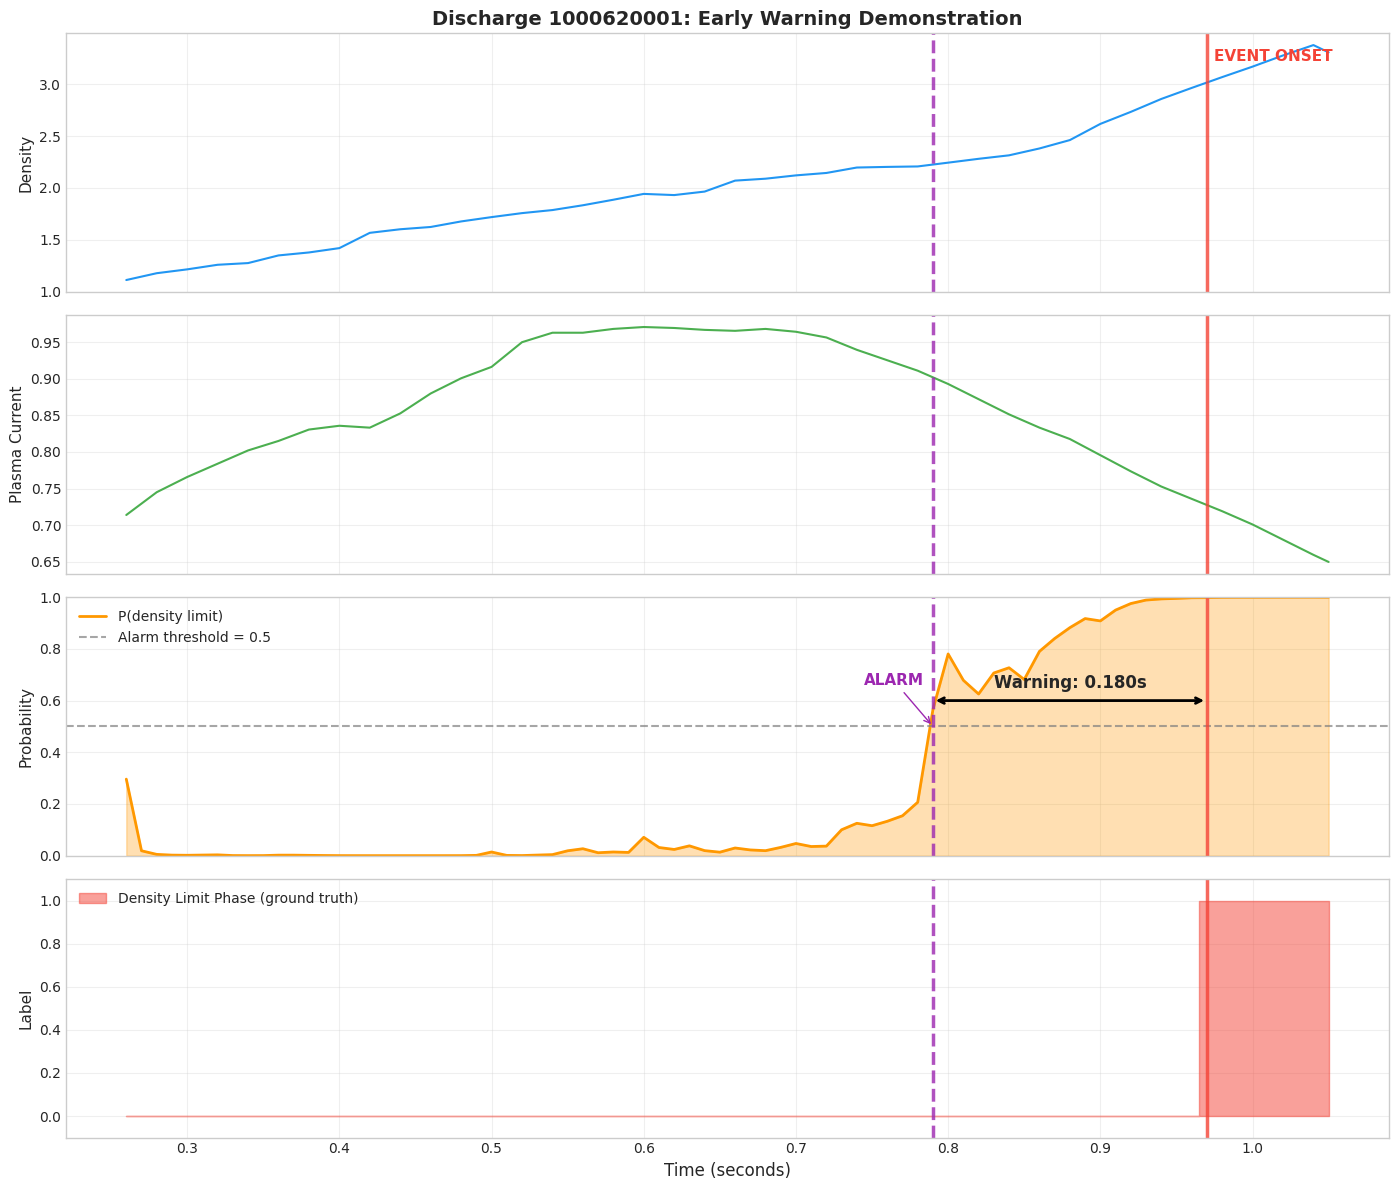


✓ Figure saved to results/demo_discharge.png


In [8]:
# Create visualization
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

colors = {
    'density': '#2196F3',
    'current': '#4CAF50',
    'prob': '#FF9800',
    'event': '#F44336',
    'alarm': '#9C27B0'
}

# Panel 1: Density
ax1 = axes[0]
ax1.plot(time, discharge_df['density'].values, color=colors['density'], linewidth=1.5)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title(f'Discharge {selected_discharge}: Early Warning Demonstration', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Panel 2: Plasma Current
ax2 = axes[1]
ax2.plot(time, discharge_df['plasma_current'].values, color=colors['current'], linewidth=1.5)
ax2.set_ylabel('Plasma Current', fontsize=11)
ax2.grid(True, alpha=0.3)

# Panel 3: Predicted Probability
ax3 = axes[2]
ax3.fill_between(time, 0, discharge_probs, color=colors['prob'], alpha=0.3)
ax3.plot(time, discharge_probs, color=colors['prob'], linewidth=2, label='P(density limit)')
ax3.axhline(y=THRESHOLD, color='gray', linestyle='--', alpha=0.7, 
            label=f'Alarm threshold = {THRESHOLD}')
ax3.set_ylabel('Probability', fontsize=11)
ax3.set_ylim([0, 1])
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3)

# Panel 4: Ground Truth Label
ax4 = axes[3]
ax4.fill_between(time, 0, labels, color=colors['event'], alpha=0.5, step='mid',
                 label='Density Limit Phase (ground truth)')
ax4.set_ylabel('Label', fontsize=11)
ax4.set_xlabel('Time (seconds)', fontsize=12)
ax4.set_ylim([-0.1, 1.1])
ax4.legend(loc='upper left', fontsize=10)
ax4.grid(True, alpha=0.3)

# Add vertical lines for event and alarm
if event_start:
    for ax in axes:
        ax.axvline(x=event_start, color=colors['event'], linestyle='-', linewidth=2.5, alpha=0.8)
    axes[0].annotate('EVENT ONSET', xy=(event_start, ax1.get_ylim()[1]),
                     xytext=(5, -20), textcoords='offset points',
                     fontsize=11, color=colors['event'], fontweight='bold')

if first_alarm:
    for ax in axes:
        ax.axvline(x=first_alarm, color=colors['alarm'], linestyle='--', linewidth=2.5, alpha=0.8)
    axes[2].annotate('ALARM', xy=(first_alarm, 0.5),
                     xytext=(-50, 30), textcoords='offset points',
                     fontsize=11, color=colors['alarm'], fontweight='bold',
                     arrowprops=dict(arrowstyle='->', color=colors['alarm']))

# Add warning time annotation
if event_start and first_alarm and first_alarm < event_start:
    mid_point = (first_alarm + event_start) / 2
    axes[2].annotate('', xy=(event_start, 0.6), xytext=(first_alarm, 0.6),
                     arrowprops=dict(arrowstyle='<->', color='black', lw=2))
    axes[2].annotate(f'Warning: {warning_time:.3f}s', xy=(mid_point, 0.65),
                     ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/demo_discharge.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Figure saved to results/demo_discharge.png")

## 5. Alarm-Level Evaluation

Traditional ML metrics (accuracy, AUC) don't capture what matters for an early warning system:
- **Event Recall**: What % of events did we detect BEFORE they occurred?
- **Warning Time**: How much advance notice do we provide?
- **False Alarm Rate**: How many false alarms per discharge?

In [9]:
# Configure alarm policy
alarm_config = AlarmConfig(
    threshold=0.5,
    n_consecutive=2,     # Require 2 consecutive predictions
    use_ema=True,        # Apply exponential smoothing
    ema_alpha=0.3
)

# Compute alarm-level metrics on full test set
metrics = compute_alarm_metrics(test_df, test_probs, alarm_config)

print("=" * 50)
print(" Alarm-Level Evaluation Results")
print("=" * 50)
print(f"\nEvent Detection:")
print(f"  Events in test set:  {metrics.n_event_discharges}")
print(f"  Events detected:     {metrics.n_events_detected}")
print(f"  Event Recall:        {metrics.event_recall:.1%}")

print(f"\nFalse Alarms:")
print(f"  Non-event discharges: {metrics.n_non_event_discharges}")
print(f"  Total false alarms:   {metrics.n_false_alarms}")
print(f"  FA per discharge:     {metrics.false_alarms_per_discharge:.2f}")

warning_times = [w for w in metrics.warning_times if w > 0]
if warning_times:
    print(f"\nWarning Times (for detected events):")
    print(f"  Median: {np.median(warning_times):.4f}s")
    print(f"  Mean:   {np.mean(warning_times):.4f}s")
    print(f"  Max:    {np.max(warning_times):.4f}s")

 Alarm-Level Evaluation Results

Event Detection:
  Events in test set:  9
  Events detected:     3
  Event Recall:        33.3%

False Alarms:
  Non-event discharges: 343
  Total false alarms:   3018
  FA per discharge:     8.57

Warning Times (for detected events):
  Median: 0.0500s
  Mean:   0.0767s
  Max:    0.1400s


## 6. Threshold Trade-off Analysis

There's a fundamental trade-off: lower thresholds catch more events but generate more false alarms.

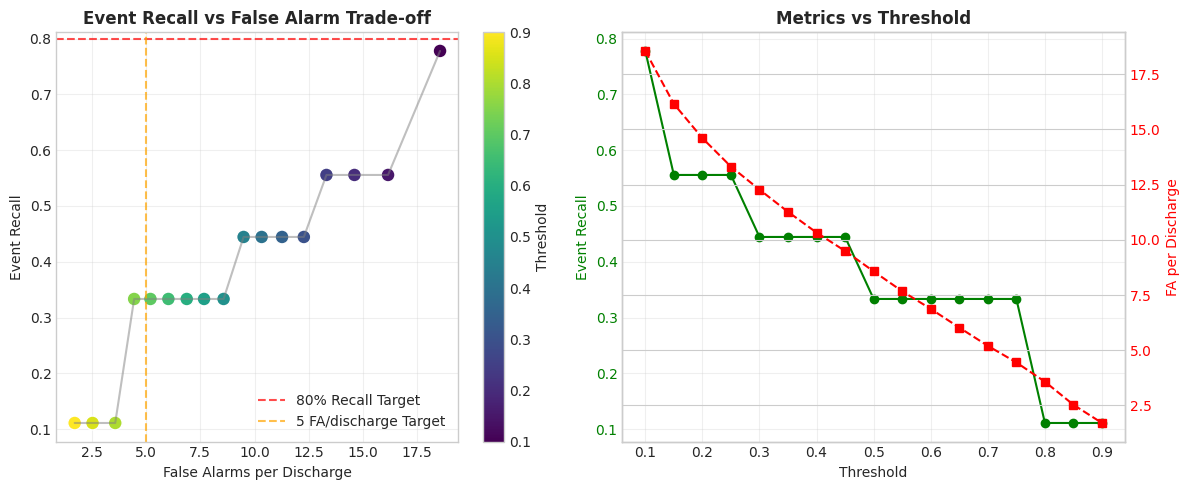

In [10]:
# Sweep thresholds
thresholds = np.linspace(0.1, 0.9, 17)
recalls = []
fars = []
warnings = []

for thresh in thresholds:
    cfg = AlarmConfig(threshold=thresh, n_consecutive=2, use_ema=True, ema_alpha=0.3)
    m = compute_alarm_metrics(test_df, test_probs, cfg)
    recalls.append(m.event_recall)
    fars.append(m.false_alarms_per_discharge)
    wts = [w for w in m.warning_times if w > 0]
    warnings.append(np.median(wts) if wts else 0)

# Plot trade-off
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: Recall vs FAR
scatter = ax1.scatter(fars, recalls, c=thresholds, cmap='viridis', s=100, edgecolors='white')
ax1.plot(fars, recalls, '-', color='gray', alpha=0.5)
ax1.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% Recall Target')
ax1.axvline(x=5, color='orange', linestyle='--', alpha=0.7, label='5 FA/discharge Target')
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Threshold')
ax1.set_xlabel('False Alarms per Discharge')
ax1.set_ylabel('Event Recall')
ax1.set_title('Event Recall vs False Alarm Trade-off', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: All three metrics vs threshold
ax2.plot(thresholds, recalls, 'o-', label='Event Recall', color='green')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Event Recall', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax2b = ax2.twinx()
ax2b.plot(thresholds, fars, 's--', label='FA/Discharge', color='red')
ax2b.set_ylabel('FA per Discharge', color='red')
ax2b.tick_params(axis='y', labelcolor='red')

ax2.set_title('Metrics vs Threshold', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🎯 Key Takeaways

1. **Early warning is achievable**: The model can detect density limit events before they occur, providing valuable warning time.

2. **Alarm-level metrics matter**: Traditional ML metrics don't tell the full story. Event recall, warning time, and false alarm rate are what matter operationally.

3. **Trade-offs exist**: Lower thresholds catch more events but generate more false alarms. The optimal operating point depends on the cost of missed events vs. false alarms.

4. **Physics-informed features help**: Features like the Greenwald fraction and temporal derivatives capture the physics of density limit approach.

---

For better performance, train the full TCN model:
```bash
python scripts/train_tcn.py
```